In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.utils import check_array
from keras.models import load_model
from keras.layers import Bidirectional
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from numpy import array
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers import Dense,LSTM,Dropout,Activation
import os
from sklearn.metrics import mean_absolute_percentage_error
from pandas import DataFrame

In [2]:
df=pd.read_csv('alpha_cases.csv')
df.head()

infection
0       8010
1      16520
2      25015
3      33540
4      41944

In [3]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 

In [4]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1980/3151536076.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1980/3151536076.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [5]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [149]:
n_past = 5
n_future =3
n_features = 1

In [150]:
X_train, y_train = split_series(train.values,n_past, n_future)

In [151]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [189]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 1)]       0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 5, 100),     40800       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_7 (LSTM)                  [(None, 100),        80400       ['lstm_6[0][0]']                 
                                 (None, 100),                                                 

In [ ]:

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history=model.fit(X_train,y_train,epochs=100,validation_split = 0.2,batch_size=16,verbose=0)

In [152]:
model=load_model("LSTM_3days.h5")
#model=model.save("LSTM_3days.h5")

In [153]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

pred3LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}


for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3LSTM[i],"red",linestyle='dashed')
    #plt.title("Encoder decoder LSTM", fontdict = font1)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
    


In [154]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.03945710317965305
Day  2 :
MAE-E2D2 :  0.01983004283824583
Day  3 :
MAE-E2D2 :  0.01545905289733556


mean 0.024915399638411478


In [155]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  2.968983387130395
Day  2 :
MAE-E2D2 :  1.587305623089428
Day  3 :
MAE-E2D2 :  1.229593658762265


mean 1.9286275563273625


In [14]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   



infection
Day  1 :
MAE-E2D2 :  0.043036036980470135
Day  2 :
MAE-E2D2 :  0.02368767562234731
Day  3 :
MAE-E2D2 :  0.01931373753186597


mean 0.028679150044894474


In [15]:
#residual plot

residuals = y_test-pred3LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    


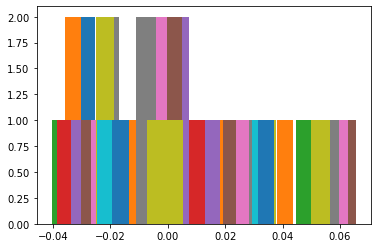

In [16]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

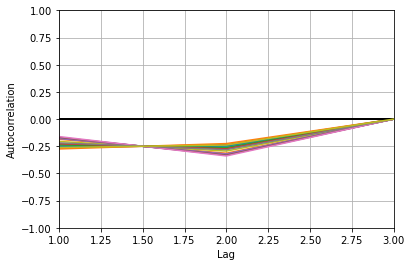

In [17]:
from pandas.plotting import autocorrelation_plot
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [21]:
model=load_model("LSTM_5days.h5")
#model=model.save("LSTM_5days.h5")

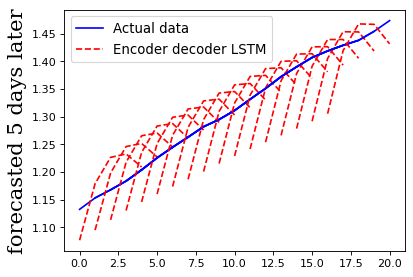

In [22]:
pred5LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"red",linestyle='dashed')
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    #plt.xlabel("days")   
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=12)
#plt.legend()

In [23]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.08036879897601369
Day  2 :
MAE-E2D2 :  0.01729709375721671
Day  3 :
MAE-E2D2 :  0.041595761748786125
Day  4 :
MAE-E2D2 :  0.027209849629091395
Day  5 :
MAE-E2D2 :  0.020404347786641235


mean 0.037375170379549835


In [24]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  6.204841714184341
Day  2 :
MAE-E2D2 :  1.3810938059294287
Day  3 :
MAE-E2D2 :  3.253915824225378
Day  4 :
MAE-E2D2 :  2.1234800758300807
Day  5 :
MAE-E2D2 :  1.4557997918102692


mean 2.8838262423959


In [25]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


infection
Day  1 :
MAE-E2D2 :  0.08310875445556469
Day  2 :
MAE-E2D2 :  0.019568431120777937
Day  3 :
MAE-E2D2 :  0.044092055332502496
Day  4 :
MAE-E2D2 :  0.03089088707412141
Day  5 :
MAE-E2D2 :  0.02532166014667064


mean 0.040596357625927434


In [33]:
#residual plot

residuals = y_test-pred5LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

infection
Day  1 :
R_value 0.9979494648084327
Day  2 :
R_value 0.998158901308749
Day  3 :
R_value 0.99840307251509
Day  4 :
R_value 0.9985162253063804
Day  5 :
R_value 0.9986221585778352
R_value.mean 0.9983299645032975


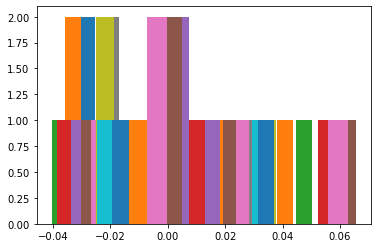

In [26]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

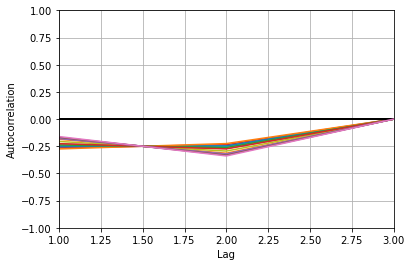

In [27]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [31]:
model=load_model("LSTM_7days.h5")
#model=model.save("LSTM_7days.h5")

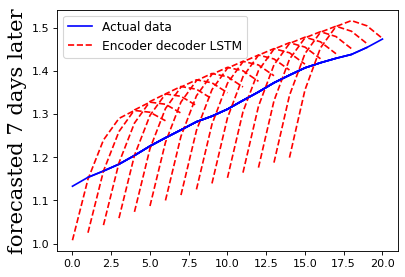

In [32]:
pred7LSTM=model.predict(X_test)
font1 = {'family':'Serif','color':'black','size':19}
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','Encoder decoder LSTM'],fontsize=11)


In [33]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.15052095604241778
Day  2 :
MAE-E2D2 :  0.01977260756047318
Day  3 :
MAE-E2D2 :  0.05716475233902195
Day  4 :
MAE-E2D2 :  0.08947918770136173
Day  5 :
MAE-E2D2 :  0.0884290555980946
Day  6 :
MAE-E2D2 :  0.06332296551554349
Day  7 :
MAE-E2D2 :  0.021974238603032263


mean 0.070094823337135


In [34]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  11.885138237525794
Day  2 :
MAE-E2D2 :  1.476648370566677
Day  3 :
MAE-E2D2 :  4.490717359382271
Day  4 :
MAE-E2D2 :  6.890314635831228
Day  5 :
MAE-E2D2 :  6.714753699685799
Day  6 :
MAE-E2D2 :  4.759803119059194
Day  7 :
MAE-E2D2 :  1.6658239915433353


mean 5.4118856305134715


In [35]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7LSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))   


infection
Day  1 :
MAE-E2D2 :  0.1520267766975582
Day  2 :
MAE-E2D2 :  0.02565561157031413
Day  3 :
MAE-E2D2 :  0.05893918005420284
Day  4 :
MAE-E2D2 :  0.09039770587593028
Day  5 :
MAE-E2D2 :  0.08924040290129358
Day  6 :
MAE-E2D2 :  0.06448753880203205
Day  7 :
MAE-E2D2 :  0.02585372587463567


mean 0.0723715631108524


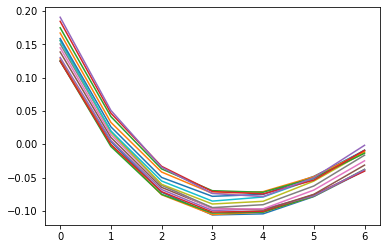

In [36]:
#residual plot

residuals = y_test-pred7LSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)
    

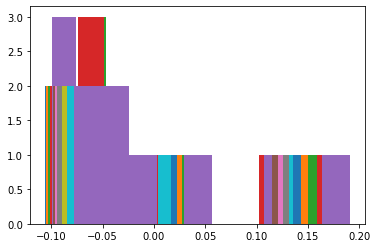

In [37]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

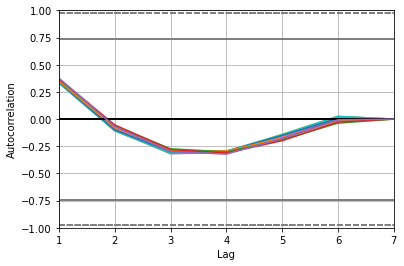

In [38]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)

In [ ]:
#BiLSTM

In [5]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1980/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_1980/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [6]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [21]:
n_past = 5
n_future =7
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [22]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [80]:
#define model
model = Sequential()
model.add(Bidirectional(LSTM(150, return_sequences=True), input_shape=(n_past, n_features)))
model.add(Bidirectional(LSTM(128,activation='relu')))
model.add(Dense(128))
model.add(Dense(n_future))
model.compile(loss='mean_squared_error', optimizer='Adam')

In [81]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2, batch_size = 16)

Epoch 1/100
4/4 [==============================] - 11s 625ms/step - loss: 0.2686 - val_loss: 0.5160
Epoch 2/100
4/4 [==============================] - 0s 42ms/step - loss: 0.1310 - val_loss: 0.4599
Epoch 3/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0652 - val_loss: 0.3368
Epoch 4/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0400 - val_loss: 0.1921
Epoch 5/100
4/4 [==============================] - 0s 48ms/step - loss: 0.0285 - val_loss: 0.0427
Epoch 6/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0110 - val_loss: 0.0730
Epoch 7/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0070 - val_loss: 0.1185
Epoch 8/100
4/4 [==============================] - 0s 44ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 9/100
4/4 [==============================] - 0s 49ms/step - loss: 0.0015 - val_loss: 0.0353
Epoch 10/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0021 - val_loss: 0.0808
Epoch 11/100
4/4 

In [9]:
#model.save('bilstm_3days.h5')
model=load_model("bilstm_3days.h5")

In [15]:
font1 = {'family':'Serif','color':'black','size':19}

In [16]:
pred3BiLSTM=model.predict(X_test)
pred3BiLSTM = pred3BiLSTM.reshape((pred3BiLSTM.shape[0], pred3BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
#plt.legend()       

In [12]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.004516639090127006
Day  2 :
MAE-E2D2 :  0.005717682151607453
Day  3 :
MAE-E2D2 :  0.00717267441295753


mean 0.00580233188489733


In [49]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.3482738899590521
Day  2 :
MAE-E2D2 :  0.43593723980409754
Day  3 :
MAE-E2D2 :  0.5507367943457576


mean 0.4449826413696358


In [50]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.005523694320629312
Day  2 :
MAE-E2D2 :  0.006592855336161283
Day  3 :
MAE-E2D2 :  0.007846831135310383


mean 0.00665446026403366


In [15]:
#residual plot

residuals = y_test-pred3BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

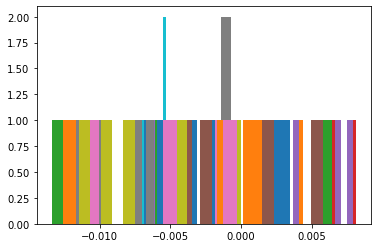

In [16]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

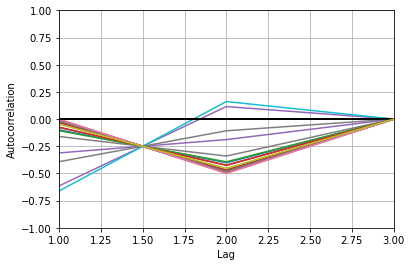

In [53]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)    

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

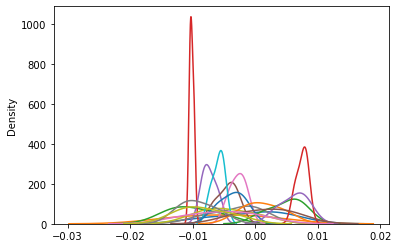

In [17]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [19]:
#model.save('bilstm_5days.h5')
model=load_model("bilstm_5days.h5")

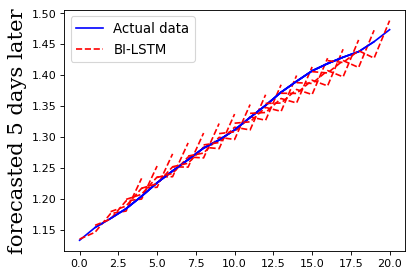

In [20]:
pred5BiLSTM=model.predict(X_test)
pred5BiLSTM= pred5BiLSTM.reshape((pred5BiLSTM.shape[0], pred5BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
      

In [22]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.006558840255322522
Day  2 :
MAE-E2D2 :  0.008362579282065082
Day  3 :
MAE-E2D2 :  0.007365228893537432
Day  4 :
MAE-E2D2 :  0.02064667057489169
Day  5 :
MAE-E2D2 :  0.019238782823811678


mean 0.01243442036592568


In [59]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  0.5248133961156904
Day  2 :
MAE-E2D2 :  0.6248160887992205
Day  3 :
MAE-E2D2 :  0.5660142947664428
Day  4 :
MAE-E2D2 :  1.5102731595336565
Day  5 :
MAE-E2D2 :  1.4615392259355926


mean 0.9374912330301207


In [60]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.007750817332261097
Day  2 :
MAE-E2D2 :  0.010353861392014333
Day  3 :
MAE-E2D2 :  0.008617316433522053
Day  4 :
MAE-E2D2 :  0.02341592196799879
Day  5 :
MAE-E2D2 :  0.020570551711209386


mean 0.01414169376740113


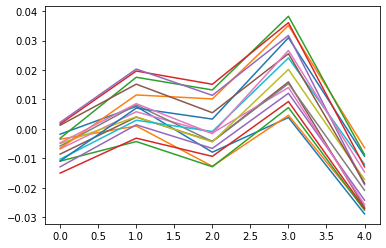

In [23]:
#residual plot

residuals = y_test-pred5BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

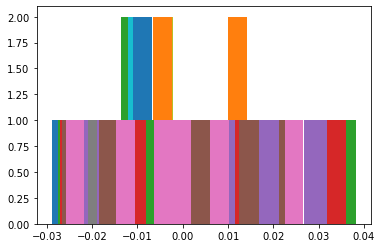

In [62]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

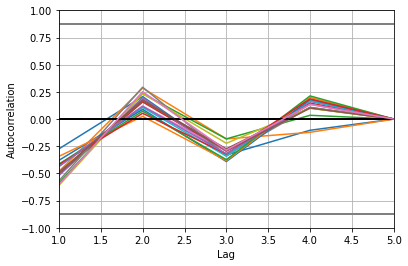

In [63]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

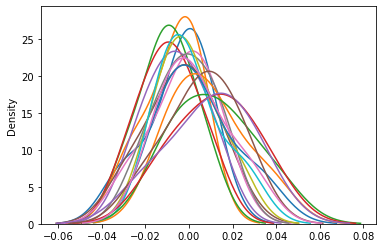

In [24]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [23]:
#model.save('bilstm_7days1.h5')
model=load_model("bilstm_7days1.h5")

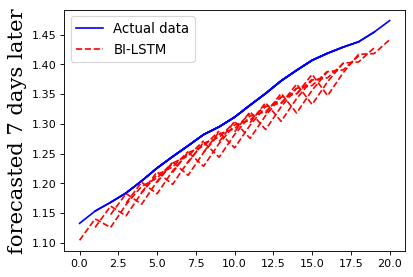

In [24]:
pred7BiLSTM=model.predict(X_test)
pred7BiLSTM = pred7BiLSTM.reshape((pred7BiLSTM.shape[0], pred7BiLSTM.shape[1],n_features))
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Actual data','BI-LSTM'],fontsize=12)
     

In [29]:
#MAE
from sklearn.metrics import mean_absolute_error
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  0.027471045179177193
Day  2 :
MAE-E2D2 :  0.01143840905213905
Day  3 :
MAE-E2D2 :  0.05446316812962633
Day  4 :
MAE-E2D2 :  0.03352207782445613
Day  5 :
MAE-E2D2 :  0.019539942357227676
Day  6 :
MAE-E2D2 :  0.028785156992187623
Day  7 :
MAE-E2D2 :  0.020616172901077437


mean 0.02797656749084163


In [69]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  2.166506163561827
Day  2 :
MAE-E2D2 :  0.8728823396870261
Day  3 :
MAE-E2D2 :  4.163379363872532
Day  4 :
MAE-E2D2 :  2.5156116359720784
Day  5 :
MAE-E2D2 :  1.4423816708962116
Day  6 :
MAE-E2D2 :  2.1067817668697733
Day  7 :
MAE-E2D2 :  1.4838114474133461


mean 2.1073363411818273


In [70]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7BiLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    



infection
Day  1 :
MAE-E2D2 :  0.02816839336897104
Day  2 :
MAE-E2D2 :  0.013286170100828491
Day  3 :
MAE-E2D2 :  0.055719644910724904
Day  4 :
MAE-E2D2 :  0.03508166796582345
Day  5 :
MAE-E2D2 :  0.021161986808987922
Day  6 :
MAE-E2D2 :  0.03038893202645315
Day  7 :
MAE-E2D2 :  0.02259264070595479


mean 0.02948563369824911


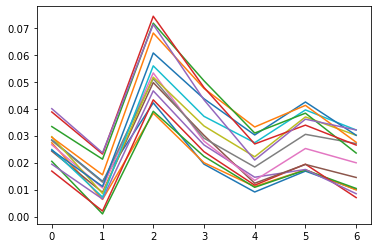

In [30]:
#residual plot

residuals = y_test-pred7BiLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

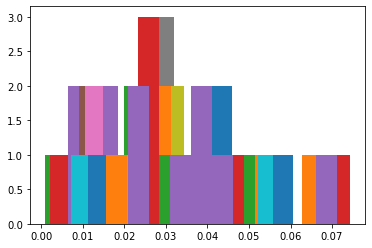

In [72]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

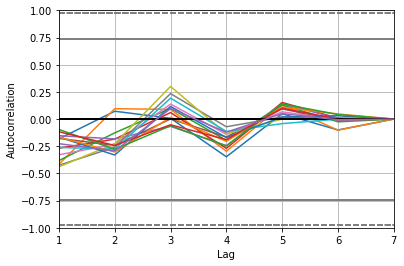

In [73]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
F:\anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

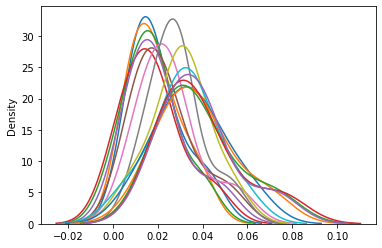

In [31]:
import seaborn as sns
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    sns.distplot(residual, hist=False)

In [ ]:
#ConvLSTM

In [162]:
n_past=4
n_future=7
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):]
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s
    
    
    
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y) 


X_train, y_train = split_series(train.values,n_past, n_future)
X_test, y_test = split_series(test.values,n_past, n_future)

n_features = 1
n_seq = 2
n_steps = 2
X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_4628/427068468.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_4628/427068468.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [64]:
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(n_future))
model.compile(optimizer='adam', loss='mse')

In [136]:
history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False)

Epoch 1/100
4/4 [==============================] - 5s 174ms/step - loss: 0.3030 - val_loss: 0.5736
Epoch 2/100
4/4 [==============================] - 0s 21ms/step - loss: 0.2914 - val_loss: 0.5694
Epoch 3/100
4/4 [==============================] - 0s 20ms/step - loss: 0.2813 - val_loss: 0.5648
Epoch 4/100
4/4 [==============================] - 0s 21ms/step - loss: 0.2712 - val_loss: 0.5601
Epoch 5/100
4/4 [==============================] - 0s 23ms/step - loss: 0.2610 - val_loss: 0.5553
Epoch 6/100
4/4 [==============================] - 0s 23ms/step - loss: 0.2505 - val_loss: 0.5503
Epoch 7/100
4/4 [==============================] - 0s 24ms/step - loss: 0.2397 - val_loss: 0.5450
Epoch 8/100
4/4 [==============================] - 0s 31ms/step - loss: 0.2284 - val_loss: 0.5393
Epoch 9/100
4/4 [==============================] - 0s 26ms/step - loss: 0.2167 - val_loss: 0.5333
Epoch 10/100
4/4 [==============================] - 0s 23ms/step - loss: 0.2045 - val_loss: 0.5268
Epoch 11/100
4/4 [

Epoch 83/100
4/4 [==============================] - 0s 22ms/step - loss: 5.1893e-04 - val_loss: 0.0035
Epoch 84/100
4/4 [==============================] - 0s 24ms/step - loss: 5.1270e-04 - val_loss: 0.0035
Epoch 85/100
4/4 [==============================] - 0s 20ms/step - loss: 5.0683e-04 - val_loss: 0.0035
Epoch 86/100
4/4 [==============================] - 0s 21ms/step - loss: 5.0128e-04 - val_loss: 0.0035
Epoch 87/100
4/4 [==============================] - 0s 20ms/step - loss: 4.9598e-04 - val_loss: 0.0035
Epoch 88/100
4/4 [==============================] - 0s 22ms/step - loss: 4.9087e-04 - val_loss: 0.0035
Epoch 89/100
4/4 [==============================] - 0s 20ms/step - loss: 4.8598e-04 - val_loss: 0.0035
Epoch 90/100
4/4 [==============================] - 0s 21ms/step - loss: 4.8126e-04 - val_loss: 0.0035
Epoch 91/100
4/4 [==============================] - 0s 20ms/step - loss: 4.7671e-04 - val_loss: 0.0035
Epoch 92/100
4/4 [==============================] - 0s 20ms/step - loss: 

In [75]:
#model.save('ConvLSTM_3days.h5')
model=load_model("ConvLSTM_3days.h5")

In [76]:
pred3ConvLSTM=model.predict(X_test)

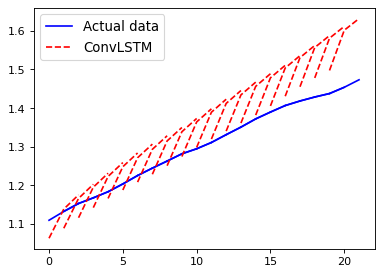

In [77]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [78]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3ConvLSTM = pred3ConvLSTM.reshape((pred3ConvLSTM.shape[0], pred3ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.023254849889751506
Day  2 :
MAE-E2D2 :  0.07238866121025525
Day  3 :
MAE-E2D2 :  0.08905370448428729


mean 0.06156573852809801


In [79]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))   

infection
Day  1 :
MAE-E2D2 :  1.8264471158776048
Day  2 :
MAE-E2D2 :  5.365220521940184
Day  3 :
MAE-E2D2 :  6.573923028565113


mean 4.588530222127634


In [80]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    




infection
Day  1 :
MAE-E2D2 :  0.028214599695342506
Day  2 :
MAE-E2D2 :  0.08218525937288623
Day  3 :
MAE-E2D2 :  0.09694126968877124


mean 0.06911370958566666


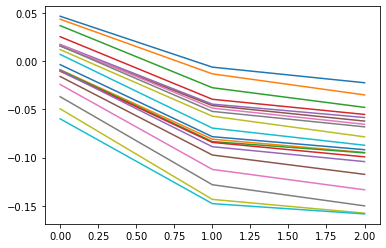

In [81]:
#residual plot

residuals = y_test-pred3ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

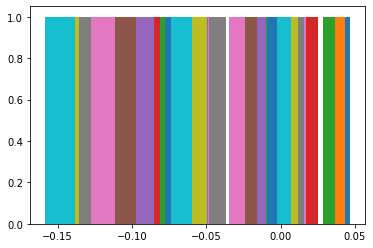

In [82]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

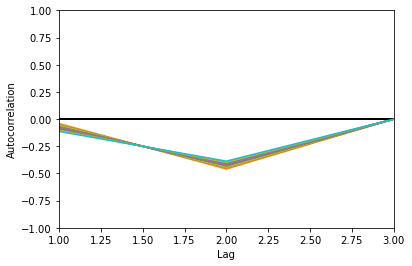

In [83]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [157]:
#model.save('ConvLSTM_5days.h5')
model=load_model("ConvLSTM_5days.h5")

In [158]:
pred5ConvLSTM=model.predict(X_test)

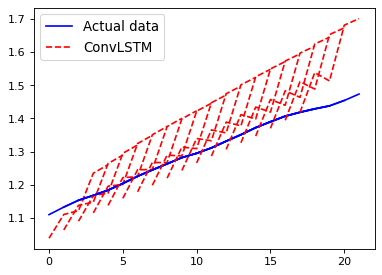

In [159]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [160]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5ConvLSTM = pred5ConvLSTM.reshape((pred5ConvLSTM.shape[0], pred5ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.03792088203276443
Day  2 :
MAE-E2D2 :  0.043946347996527066
Day  3 :
MAE-E2D2 :  0.023841240509247727
Day  4 :
MAE-E2D2 :  0.14009169395287616
Day  5 :
MAE-E2D2 :  0.14627693580801987


mean 0.07841542005988705


In [161]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    
     

infection
Day  1 :
MAE-E2D2 :  3.1133230262847817
Day  2 :
MAE-E2D2 :  3.2795276715155044
Day  3 :
MAE-E2D2 :  1.765358962820811
Day  4 :
MAE-E2D2 :  10.43690988898123
Day  5 :
MAE-E2D2 :  10.77383210003749


mean 5.873790329927964


In [90]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.042320689698402844
Day  2 :
MAE-E2D2 :  0.05285148885363547
Day  3 :
MAE-E2D2 :  0.031015773749984113
Day  4 :
MAE-E2D2 :  0.14681416793299898
Day  5 :
MAE-E2D2 :  0.15262290860495964


mean 0.08512500576799621


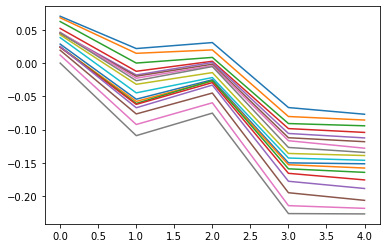

In [91]:
#residual plot

residuals = y_test-pred5ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

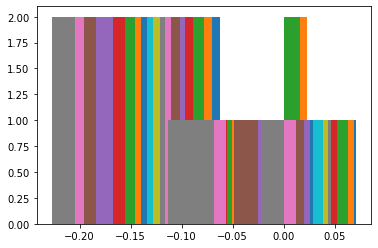

In [92]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

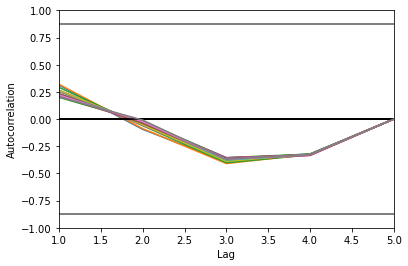

In [93]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [163]:
#model.save('ConvLSTM_7days.h5')
model=load_model("ConvLSTM_7days.h5")

In [164]:
pred7ConvLSTM=model.predict(X_test)

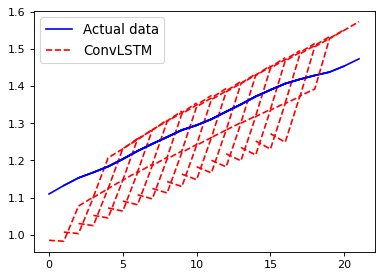

In [165]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7 days later")
    plt.legend(['Actual data','ConvLSTM'],fontsize=12)


In [166]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7ConvLSTM = pred7ConvLSTM.reshape((pred7ConvLSTM.shape[0], pred7ConvLSTM.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors))     

infection
Day  1 :
MAE-E2D2 :  0.11733237988244083
Day  2 :
MAE-E2D2 :  0.14881800472513326
Day  3 :
MAE-E2D2 :  0.056426774086206444
Day  4 :
MAE-E2D2 :  0.052820623134514966
Day  5 :
MAE-E2D2 :  0.05192401000529043
Day  6 :
MAE-E2D2 :  0.05817468878251053
Day  7 :
MAE-E2D2 :  0.06666739135026226


mean 0.07888055313805124


In [167]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))    

infection
Day  1 :
MAE-E2D2 :  9.43267131591373
Day  2 :
MAE-E2D2 :  11.753507634141513
Day  3 :
MAE-E2D2 :  4.431288197566993
Day  4 :
MAE-E2D2 :  4.089670442260831
Day  5 :
MAE-E2D2 :  3.867765497187449
Day  6 :
MAE-E2D2 :  4.281837889901466
Day  7 :
MAE-E2D2 :  4.857306343170999


mean 6.1020067600204255


In [100]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7ConvLSTM[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))    


infection
Day  1 :
MAE-E2D2 :  0.11741664732138563
Day  2 :
MAE-E2D2 :  0.14893211200122652
Day  3 :
MAE-E2D2 :  0.05688394167904692
Day  4 :
MAE-E2D2 :  0.0531775672765049
Day  5 :
MAE-E2D2 :  0.054662511891530235
Day  6 :
MAE-E2D2 :  0.061210619375712594
Day  7 :
MAE-E2D2 :  0.069473779674434


mean 0.0802510256028344


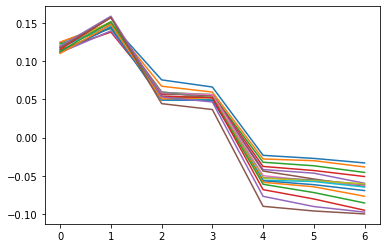

In [101]:

#residual plot

residuals = y_test-pred7ConvLSTM
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

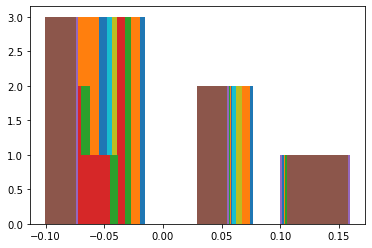

In [102]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

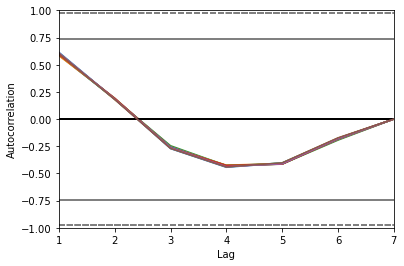

In [103]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [ ]:
#GRU

In [168]:
train_df,test_df =df[1:int(0.75 * len(df))],df[int(0.75 * len(df)):] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_4628/3905142482.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i]=s_s
C:\Users\SEPANT~1\AppData\Local\Temp/ipykernel_4628/3905142482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i]=s_s


In [169]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [184]:
n_past = 5
n_future =7
n_features = 1
X_train, y_train = split_series(train.values,n_past, n_future)

In [185]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

In [120]:
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (66, 5, 1)
y_train.shape:  (66, 5)
X_test.shape:  (17, 5, 1)
y_test.shape:  (17, 5)


In [139]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = n_future)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [140]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        )
    return history
history_gru = fit_model(model_gru)


Epoch 1/100
4/4 [==============================] - 7s 418ms/step - loss: 0.3333 - val_loss: 0.5762
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 0.2092 - val_loss: 0.4698
Epoch 3/100
4/4 [==============================] - 0s 28ms/step - loss: 0.1299 - val_loss: 0.3575
Epoch 4/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0742 - val_loss: 0.2452
Epoch 5/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0428 - val_loss: 0.1470
Epoch 6/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0340 - val_loss: 0.0826
Epoch 7/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0268 - val_loss: 0.0450
Epoch 8/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0181 - val_loss: 0.0232
Epoch 9/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0094 - val_loss: 0.0082
Epoch 10/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0096 - val_loss: 5.7423e-04
Epoch 11/100
4

In [172]:
#model_gru.save('GRU_3days.h5')
model_gru=load_model("GRU_3days.h5")

In [173]:
pred3GRU=model_gru.predict(X_test)

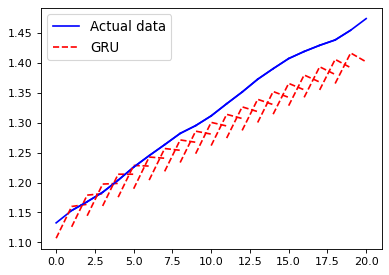

In [174]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred3GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 3 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [175]:
#MAE
from sklearn.metrics import mean_absolute_error
pred3GRU = pred3GRU.reshape((pred3GRU.shape[0], pred3GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred3GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.05078500356425484
Day  2 :
MAE-E2D2 :  0.02023601480069458
Day  3 :
MAE-E2D2 :  0.03827116831109685


mean 0.03643072889201542


In [176]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  3.832351537528679
Day  2 :
MAE-E2D2 :  1.4856314514920097
Day  3 :
MAE-E2D2 :  2.7735273815944215


mean 2.69717012353837


In [114]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred3GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.05447132192713918
Day  2 :
MAE-E2D2 :  0.024432866894641556
Day  3 :
MAE-E2D2 :  0.044577756715790874


mean 0.04116064851252387


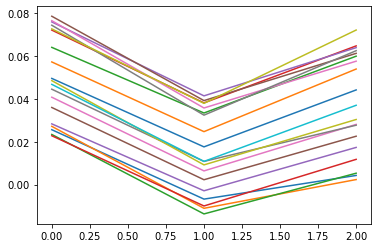

In [115]:
#residual plot

residuals = y_test-pred3GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

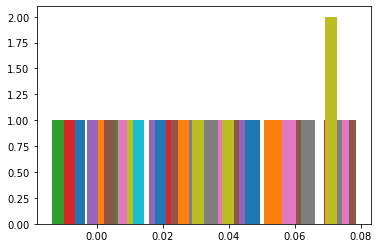

In [116]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

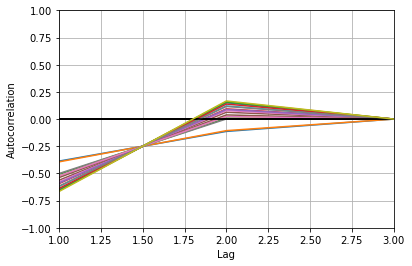

In [117]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [179]:
#model_gru.save('GRU_5days.h5')
model_gru=load_model("GRU_5days.h5")

In [180]:
pred5GRU=model_gru.predict(X_test)


In [181]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred5GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 5 days later")
    plt.legend(['Actual data','GRU'],fontsize=12)


In [182]:
#MAE
from sklearn.metrics import mean_absolute_error
pred5GRU = pred5GRU.reshape((pred5GRU.shape[0], pred5GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred5GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.017356312685178867
Day  2 :
MAE-E2D2 :  0.01929351588598144
Day  3 :
MAE-E2D2 :  0.018591695209982835
Day  4 :
MAE-E2D2 :  0.03310623793568513
Day  5 :
MAE-E2D2 :  0.05690326180455602


mean 0.029050204704276862


In [183]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


infection
Day  1 :
MAE-E2D2 :  1.3986623575427757
Day  2 :
MAE-E2D2 :  1.5209742833947926
Day  3 :
MAE-E2D2 :  1.4064970383206108
Day  4 :
MAE-E2D2 :  2.3957518781136864
Day  5 :
MAE-E2D2 :  4.110584762825055


mean 2.166494064039384


In [126]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred5GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.019643315650669815
Day  2 :
MAE-E2D2 :  0.021772590377456404
Day  3 :
MAE-E2D2 :  0.02182045691513831
Day  4 :
MAE-E2D2 :  0.04012005723869504
Day  5 :
MAE-E2D2 :  0.06376002684648092


mean 0.033423289405688096


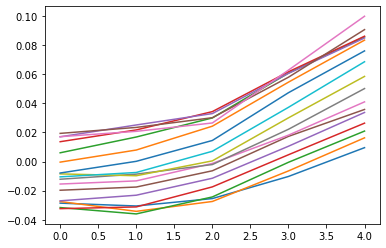

In [127]:

#residual plot

residuals = y_test-pred5GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

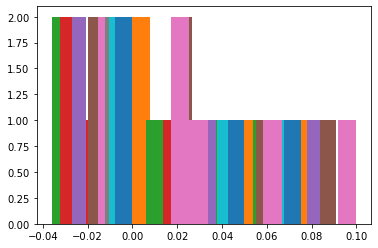

In [128]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

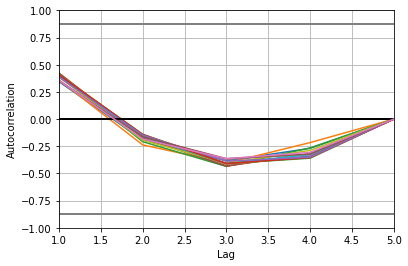

In [129]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

In [186]:
#model_gru.save('GRU_7days.h5')
model_gru=load_model("GRU_7days.h5")

In [187]:
pred7GRU=model_gru.predict(X_test)


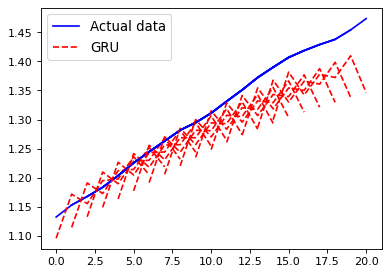

In [188]:
from matplotlib.pyplot import figure
figure(figsize=(5.5, 4), dpi=80)
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"blue")
    plt.plot(range(i,i+n_future),pred7GRU[i],"red",linestyle='dashed')
    #plt.xlabel("days")   
    #plt.ylabel("forecasted 7days later") 
    plt.legend(['Actual data','GRU'],fontsize=12)

In [189]:
#MAE
from sklearn.metrics import mean_absolute_error
pred7GRU = pred7GRU.reshape((pred7GRU.shape[0], pred7GRU.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],n_features))
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
        errors=np.append(errors,mean_absolute_error(y_test[:,j-1,index],pred7GRU[:,j-1,index]))
    print()
    print()
print("mean",np.mean(errors)) 
    

infection
Day  1 :
MAE-E2D2 :  0.056675636294492945
Day  2 :
MAE-E2D2 :  0.014338760595102966
Day  3 :
MAE-E2D2 :  0.04173964276443264
Day  4 :
MAE-E2D2 :  0.024755841912355202
Day  5 :
MAE-E2D2 :  0.039974655720875135
Day  6 :
MAE-E2D2 :  0.022209197525189312
Day  7 :
MAE-E2D2 :  0.08248676374682125


mean 0.04031149979418135


In [191]:
#MAPE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
        errors=np.append(errors,mean_absolute_percentage_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])*100)
    print()
    print()
print("mean",np.mean(errors))  


infection
Day  1 :
MAE-E2D2 :  4.428040221345689
Day  2 :
MAE-E2D2 :  1.1357603808989603
Day  3 :
MAE-E2D2 :  3.1277411985400696
Day  4 :
MAE-E2D2 :  1.8146352382872106
Day  5 :
MAE-E2D2 :  2.920613026704243
Day  6 :
MAE-E2D2 :  1.5927939238261122
Day  7 :
MAE-E2D2 :  5.956291278019752


mean 2.9965536096602916


In [138]:
#RMSE
errors=[]
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,n_future+1):
        print("Day ",j,":")
        print("MAE-E2D2 : ",math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
        errors=np.append(errors,math.sqrt(mean_squared_error(y_test[:,j-1,index],pred7GRU[:,j-1,index])))
    print()
    print()
print("mean",np.mean(errors))  



infection
Day  1 :
MAE-E2D2 :  0.05941167808046605
Day  2 :
MAE-E2D2 :  0.016589857975350602
Day  3 :
MAE-E2D2 :  0.04733224796679384
Day  4 :
MAE-E2D2 :  0.030862318616913315
Day  5 :
MAE-E2D2 :  0.04564249541045419
Day  6 :
MAE-E2D2 :  0.027669399738226175
Day  7 :
MAE-E2D2 :  0.08716722179362874


mean 0.0449536027974047


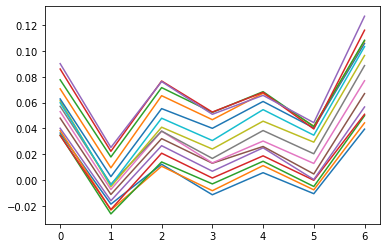

In [139]:
#residual plot

residuals = y_test-pred7GRU
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.plot(residual)

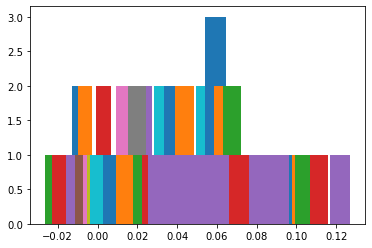

In [140]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    plt.hist(residual)

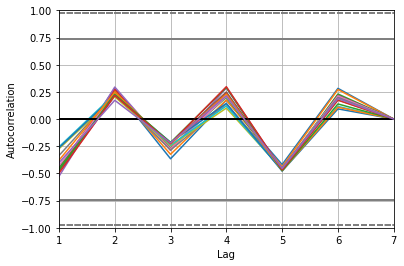

In [141]:
for i in range(len(y_test)):
    residual = DataFrame(residuals[i])
    autocorrelation_plot(residual)  

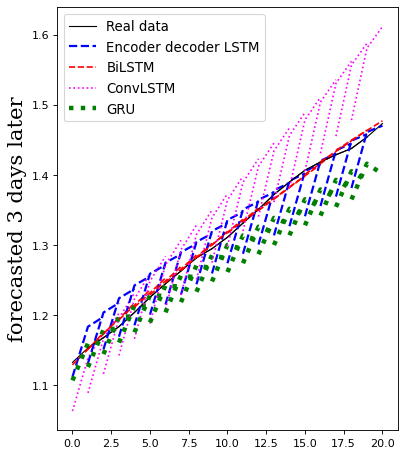

In [185]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)
font1 = {'family':'Serif','color':'black','size':19}
for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black",linewidth=1)
    plt.plot(range(i,i+n_future),pred3LSTM[i],"blue",linestyle='dashed',linewidth=2)
    plt.plot(range(i,i+n_future),pred3BiLSTM[i],"red",linestyle='dashed')
    plt.plot(range(i,i+n_future),pred3ConvLSTM[i],"magenta",linestyle='dotted')
    plt.plot(range(i,i+n_future),pred3GRU[i],"green",linestyle='dotted',linewidth=4)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 3 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()

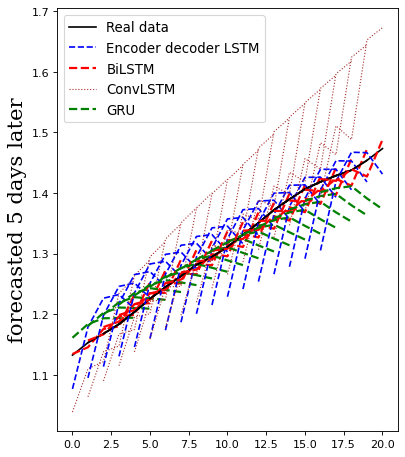

In [52]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred5LSTM[i],"blue",linestyle='dashed',linewidth=1.5)
    plt.plot(range(i,i+n_future),pred5BiLSTM[i],"red",linestyle='dashed',linewidth=2)
    plt.plot(range(i,i+n_future),pred5ConvLSTM[i],"brown",linestyle='dotted',linewidth=1)
    plt.plot(range(i,i+n_future),pred5GRU[i],"green",linestyle='dashed',linewidth=2)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 5 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=12)
#plt.legend()

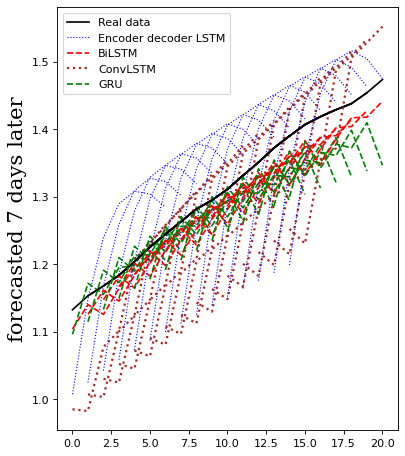

In [75]:
from matplotlib.pyplot import figure
figure(figsize=(5.5,7), dpi=80)

for i in range(len(y_test)):
    plt.plot(range(i,i+n_future),y_test[i],"black")
    plt.plot(range(i,i+n_future),pred7LSTM[i],"blue",linestyle='dotted',linewidth=1)
    plt.plot(range(i,i+n_future),pred7BiLSTM[i],"red",linestyle='dashed')
    plt.plot(range(i,i+n_future),pred7ConvLSTM[i],"brown",linestyle='dotted',linewidth=2)
    plt.plot(range(i,i+n_future),pred7GRU[i],"green",linestyle='dashed',linewidth=1.5)
    #plt.xlabel("days")   
    plt.ylabel("forecasted 7 days later", fontdict = font1)
    plt.legend(['Real data','Encoder decoder LSTM','BiLSTM','ConvLSTM','GRU'],fontsize=10)
#plt.legend()